In [1]:
import torch
import numpy as np
import pickle
import copy
import matplotlib.pyplot as plt

## CONFIG

In [2]:


###########
FLAG_TRAIN_ALL_TASKS = False
SUBSET_SIZE = 20

NUM_SAMPLES = 30
dm = 15
NUM_FEATURES = int(NUM_SAMPLES * dm)
STD = 0.01
NUM_CLUSTERS = 2
NUM_CLIENTS = 3500
NUM_ROUNDS = 1000
LEARNING_RATE = 0.01
NUM_RUNS = 8

NUM_SAMPLED_NODES = 80


## ALGORITHM

In [3]:
def create_true_underlying_w(num_features):
    one_hotted_GT = torch.from_numpy(np.eye(NUM_CLUSTERS)[np.random.choice(NUM_CLUSTERS,
                                                                           NUM_CLIENTS)].T)  # creates a matrix and indicates which client belongs to which cluster it has k rows and n coloumns
    core_GT_weights = torch.from_numpy(np.random.uniform(low=-10, high=10, size=(num_features, NUM_CLUSTERS)))  # (d, k)
    clients_GT_weights = core_GT_weights @ one_hotted_GT  # (d, n) = (d, k) @ (k, n)

    return one_hotted_GT, clients_GT_weights


class Client:
    def __init__(self, num_samples, num_features, weights, true_w, STD):
        self.weights = weights

        self.X, self.y = generate_data(num_samples, num_features,
                                       true_w, STD)
        self.GT_w = true_w

    def get_local_loss(self, weights):
        prediction = self.X @ weights
        loss_ = ((prediction - self.y) ** 2).mean()
        return loss_

    def train_locally(self, L, lr):
        weights = self.weights.clone()
        for l in range(0, L):
            weights.requires_grad_()
            weights.grad = None
            prediction = self.X @ weights
            loss_ = ((prediction - self.y) ** 2).mean()
            loss_.backward()
            grad = weights.grad.clone()
            with torch.no_grad():
                weights = weights - lr * grad
        self.weights = weights.detach()
        return weights.detach()

    def eval(self, weights):
        with torch.no_grad():
            return ((self.GT_w - weights).norm(p=2)).item()


def generate_data(num_samples, num_features, true_w, STD):
    """Generate synthetic data for a user."""
    X = torch.randn(num_samples, num_features, dtype=torch.float64)
    y = X @ true_w + STD * torch.randn(num_samples, 1)
    return X, y


def get_clients_list(num_features, clients_GT_weights):
    w_init_mat = torch.randn(num_features, NUM_CLIENTS, requires_grad=False, dtype=torch.float64)
    clients_list = []
    for client_iter in range(NUM_CLIENTS):
        GT_w = clients_GT_weights[:, client_iter].reshape(-1, 1)
        w = w_init_mat[:, client_iter].reshape(-1, 1).clone()
        clients_list.append(Client(NUM_SAMPLES, num_features, w, GT_w, STD))
    return clients_list


def find_w_candidate(current_weight, X, y, lr):
    current_weight.requires_grad_()
    current_weight.grad = None
    prediction = X @ current_weight
    loss_ = ((prediction - y) ** 2).mean()
    loss_.backward()
    with torch.no_grad():
        w_candidate = current_weight - lr * current_weight.grad
    return w_candidate


def get_w_candidates(clients_list, curr_client_id, num_features, client_ids, lr):
    curr_weight = clients_list[curr_client_id].weights.clone()
    candidates = torch.zeros((num_features, SUBSET_SIZE), dtype=torch.float64)
    for iter_client in range(SUBSET_SIZE):
        id_ = client_ids[iter_client]
        client = clients_list[id_]
        w_iter = find_w_candidate(curr_weight.clone(), client.X, client.y, lr)
        candidates[:, iter_client] = w_iter.clone().squeeze()
    return candidates


def get_w_with_best_reward(num_features, candidates, client_ids, client):
    current_loss = client.get_local_loss(client.weights)
    rewards = torch.empty((SUBSET_SIZE), dtype=torch.float64)
    for iter_client in range(SUBSET_SIZE):
        rewards[iter_client] = current_loss - client.get_local_loss(candidates[:, iter_client].reshape(num_features, 1))
    idx_max_reward = torch.argmax(rewards)
    return candidates[:, idx_max_reward], client_ids[idx_max_reward].item(), rewards[idx_max_reward].item()


def get_random_indices_without_i():
    indices = np.arange(0, NUM_CLIENTS)
    total_client_ids = np.empty((SUBSET_SIZE, NUM_CLIENTS), dtype=int)

    for iter_client in range(NUM_CLIENTS):
        available_indices = np.delete(indices, iter_client)
        random_indices = np.random.choice(available_indices, size=SUBSET_SIZE, replace=False)
        total_client_ids[:, iter_client] = random_indices
    return total_client_ids


def algorithm(clients_list, num_features, num_rounds, lr, sampled_clients, training_all_tasks=1):

    mat_history_rewards = np.empty((num_rounds, NUM_CLIENTS))
    mat_history_idx_best_candid = np.empty((num_rounds, NUM_CLIENTS), dtype=int)
    hist_loss = np.empty((num_rounds, NUM_CLIENTS))
    hist_loss_valid = np.empty((num_rounds, NUM_CLIENTS))
    norm_grad = np.empty((num_rounds, NUM_CLIENTS))
    print("Starting Training of Algorithm")

    for round_ in range(num_rounds):
        total_subsets = get_random_indices_without_i()
        w_mat = torch.zeros((num_features, NUM_CLIENTS), dtype=torch.float64)
        if round_ % 100 == 0: 
            print(f"Current Round is {round_}")
        for iter_client in range(NUM_CLIENTS):
            if (not training_all_tasks) and (iter_client not in sampled_clients):
                continue
            curr_client_candidates = get_w_candidates(clients_list, iter_client, num_features,
                                                      total_subsets[:, iter_client], lr)

            w_mat[:, iter_client], mat_history_idx_best_candid[round_, iter_client], mat_history_rewards[round_,
            iter_client] = get_w_with_best_reward(num_features,
                                                  curr_client_candidates, total_subsets[:, iter_client],
                                                  clients_list[iter_client])

            grad = w_mat[:, iter_client].reshape(-1, 1) - clients_list[iter_client].weights
            norm_grad[round_, iter_client] = np.linalg.norm(grad)

        loss = []
        loss_valid = []

        for iter_client in range(NUM_CLIENTS):
            loss.append(clients_list[iter_client].eval(clients_list[iter_client].weights.detach()))
            loss_valid.append(clients_list[iter_client].get_local_loss(clients_list[iter_client].weights.detach()).item())
            clients_list[iter_client].weights = w_mat[:, iter_client].clone().reshape(-1, 1)
        hist_loss[round_, :] = loss
        hist_loss_valid[round_, :] = loss_valid
    return mat_history_rewards, mat_history_idx_best_candid, hist_loss, hist_loss_valid, norm_grad


In [4]:

def oracle_algo(clients_list, one_hotted_gt, lr, sampled_clients, training_all_tasks=-1):
    # we want to sample gradients from each cluster then compare with our.

    num_clusters = one_hotted_gt.shape[0]
    indices = np.argmax(one_hotted_gt, axis=0)
    num_features = clients_list[0].X.shape[1]
    w_mat = torch.zeros((num_features, NUM_CLIENTS), dtype=torch.float64)

    hist_loss = np.empty((NUM_ROUNDS, NUM_CLIENTS))
    hist_loss_valid = np.empty((NUM_ROUNDS, NUM_CLIENTS))
    print("Starting Training in for Oracle")
    for round_ in range(NUM_ROUNDS):
        if round_ % 100 == 0:
            print(f"Current Round is {round_}")
        for iter_client in range(NUM_CLIENTS):
            if (not training_all_tasks) and (iter_client not in sampled_clients):
                continue
            client_cluster = indices[iter_client].item()
            temp_available_clients = indices == client_cluster
            available_clients = [i for i,flag in zip(clients_list,temp_available_clients) if flag]
            candidate = random.sample(available_clients, 1)[0]
            curr_w = clients_list[iter_client].weights.clone()
            w_mat[:, iter_client] = find_w_candidate(curr_w, candidate.X, candidate.y, lr).squeeze().clone()

        loss = []
        loss_valid = []
        for iter_client in range(NUM_CLIENTS):
            loss.append(clients_list[iter_client].eval(clients_list[iter_client].weights.detach()))
            loss_valid.append(clients_list[iter_client].get_local_loss(clients_list[iter_client].weights.detach()).item())
            clients_list[iter_client].weights = w_mat[:, iter_client].clone().reshape(-1, 1)
        hist_loss[round_, :] = loss
        hist_loss_valid[round_, :] = loss_valid

    return hist_loss, hist_loss_valid

In [5]:
def change_clients_w_init(clients_list, w_init_mat):

    for client_iter in range(NUM_CLIENTS):
        clients_list[client_iter].weights = w_init_mat[:, client_iter].reshape(-1, 1)
    return clients_list

In [6]:
def pickle_objects(directory, *args):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    frame = inspect.currentframe().f_back
    for i, obj in enumerate(args, start=1):
        var_name = None
        for name, value in frame.f_locals.items():
            if value is obj:
                var_name = name
                break
        if var_name is None:
            var_name = f'object_{i}'
        filename = os.path.join(directory, f'{var_name}.pkl')
        with open(filename, 'wb') as f:
            pickle.dump(obj, f)
        print(f'Object {i} pickled and saved as {filename}')

## PUTTING THINGS TOGETHER

In [7]:
import copy
import random
import matplotlib.pyplot as plt
import pickle
import inspect
import os

ONE_HOTTED_GT, CLIENT_GT_WEIGHT = create_true_underlying_w(NUM_FEATURES)

hist_MSE_w = np.empty((NUM_RUNS, NUM_ROUNDS, NUM_CLIENTS))
hist_MSE_y = np.empty((NUM_RUNS, NUM_ROUNDS, NUM_CLIENTS))

hist_MSE_w_oracle = np.empty((NUM_RUNS, NUM_ROUNDS, NUM_CLIENTS))
hist_MSE_y_oracle = np.empty((NUM_RUNS, NUM_ROUNDS, NUM_CLIENTS))

sampled_nodes_idx = np.random.choice(np.arange(NUM_CLIENTS), size=NUM_SAMPLED_NODES, replace=False)

for iter_run in range(NUM_RUNS):
    print("__________________________________")
    print(f"Run Number {iter_run}")
    
    clients_ls_orig = get_clients_list(NUM_FEATURES, CLIENT_GT_WEIGHT)
    clients_ls = copy.deepcopy(clients_ls_orig)
    _, _, hist_loss_w, hist_loss_valid, _ = algorithm(clients_ls,
                                                     NUM_FEATURES,
                                                     NUM_ROUNDS,
                                                     LEARNING_RATE,
                                                    sampled_nodes_idx,
                                                      FLAG_TRAIN_ALL_TASKS
                                                      )
    clients_ls = copy.deepcopy(clients_ls_orig)
    hist_MSE_w_oracle[iter_run, :, :], hist_MSE_y_oracle[iter_run, :, :] = oracle_algo(clients_ls,
                                                                                       ONE_HOTTED_GT,
                                                                                       LEARNING_RATE,
                                                                                       sampled_nodes_idx,                             
                                                                                      FLAG_TRAIN_ALL_TASKS)

    hist_MSE_w[iter_run, :, :] = hist_loss_w
    hist_MSE_y[iter_run, :, :] = hist_loss_valid

    pickle_objects("saved_var", hist_MSE_y, hist_MSE_w,  hist_MSE_y_oracle, hist_MSE_w_oracle)
    


__________________________________
Run Number 0
Starting Training of Algorithm
Current Round is 0
Current Round is 100
Current Round is 200
Current Round is 300
Current Round is 400
Current Round is 500
Current Round is 600
Current Round is 700
Current Round is 800
Current Round is 900
Starting Training in for Oracle
Current Round is 0
Current Round is 100
Current Round is 200
Current Round is 300
Current Round is 400
Current Round is 500
Current Round is 600
Current Round is 700
Current Round is 800
Current Round is 900
Object 1 pickled and saved as saved_var/hist_MSE_y.pkl
Object 2 pickled and saved as saved_var/hist_MSE_w.pkl
Object 3 pickled and saved as saved_var/hist_MSE_y_oracle.pkl
Object 4 pickled and saved as saved_var/hist_MSE_w_oracle.pkl
__________________________________
Run Number 1
Starting Training of Algorithm
Current Round is 0
Current Round is 100
Current Round is 200
Current Round is 300
Current Round is 400
Current Round is 500
Current Round is 600
Current Round i

In [8]:
if FLAG_TRAIN_ALL_TASKS != -1:
    #mean across different runs
    mean_hist_MSE_w= hist_MSE_w.mean(axis=0)
    mean_hist_MSE_y = hist_MSE_y.mean(axis=0)
    
    # getting the inspected node
    mean_hist_MSE_w = mean_hist_MSE_w[:, sampled_nodes_idx].mean(axis=1)
    mean_hist_MSE_y = mean_hist_MSE_y[:, sampled_nodes_idx].mean(axis=1)
    
    mean_hist_MSE_w_oracle = hist_MSE_w_oracle.mean(axis=0)
    mean_hist_MSE_y_oracle = hist_MSE_y_oracle.mean(axis=0)
    
    mean_hist_MSE_w_oracle = mean_hist_MSE_w_oracle[:, sampled_nodes_idx].mean(axis=1)
    mean_hist_MSE_y_oracle = mean_hist_MSE_y_oracle[:, sampled_nodes_idx].mean(axis=1)
else:
    mean_hist_MSE_w= hist_MSE_w.mean(axis=0)
    mean_hist_MSE_y = hist_MSE_y.mean(axis=0)
    
    mean_hist_MSE_w= mean_hist_MSE_w.mean(axis=1)
    mean_hist_MSE_y = mean_hist_MSE_y.mean(axis=1)
    
    mean_hist_MSE_w_oracle = hist_MSE_w_oracle.mean(axis=0)
    mean_hist_MSE_y_oracle = hist_MSE_y_oracle.mean(axis=0)
    
    mean_hist_MSE_w_oracle = mean_hist_MSE_w_oracle.mean(axis=1)
    mean_hist_MSE_y_oracle = mean_hist_MSE_y_oracle.mean(axis=1)


## SAVING VARIABLES

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/var/folders/ts/1myp2gd51_q36f7s6wsx08z80000gn/T/ipykernel_7652/114654689.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("E{${||\overline{w}^{(i)} - \hat{w}^{(i)} ||^2_2} $}", fontsize=12)


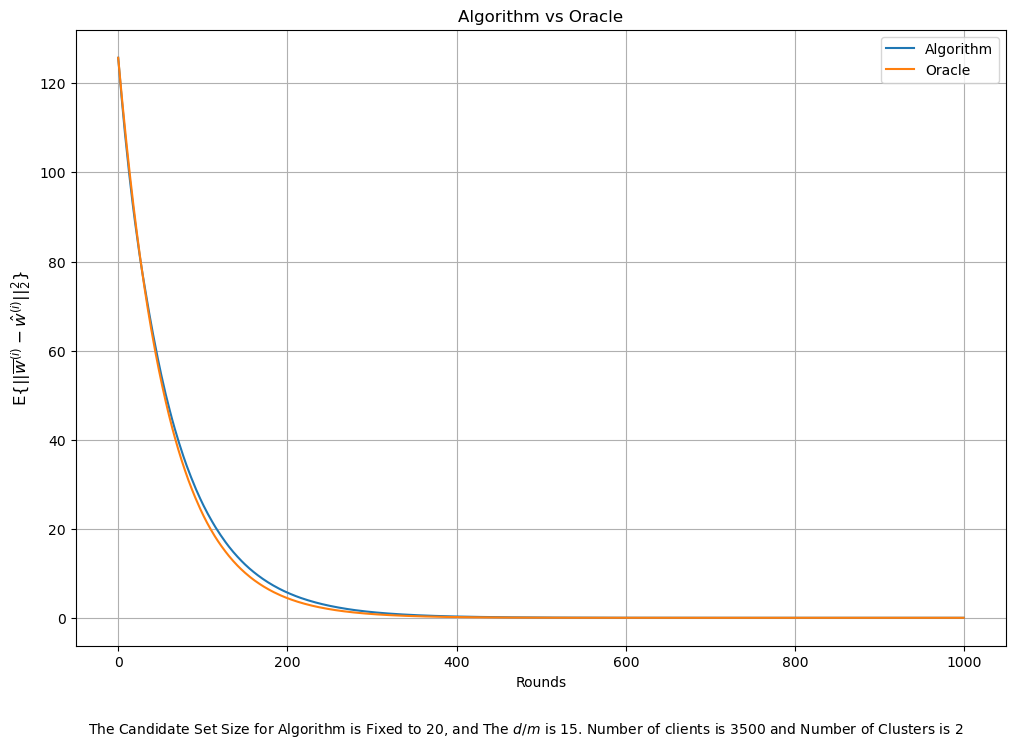

In [9]:
x = np.arange(NUM_ROUNDS)
fig = plt.figure(figsize=(12, 8))
plt.plot(x, mean_hist_MSE_w, label='Algorithm')
plt.plot(x, mean_hist_MSE_w_oracle, label='Oracle')
plt.xlabel("Rounds")
plt.ylabel("E{${||\overline{w}^{(i)} - \hat{w}^{(i)} ||^2_2} $}", fontsize=12)
plt.title("Algorithm vs Oracle")
fig.text(0.5, 0.001, f"The Candidate Set Size for Algorithm is Fixed to {SUBSET_SIZE}, and The $d/m$ is {dm}. Number of clients is {NUM_CLIENTS} and Number of Clusters is {NUM_CLUSTERS}",
         horizontalalignment="center")
plt.grid(True)  #
plt.legend()
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/var/folders/ts/1myp2gd51_q36f7s6wsx08z80000gn/T/ipykernel_7652/2555286671.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("E{${||\overline{w}^{(i)} - \hat{w}^{(i)} ||^2_2} $}", fontsize=12)


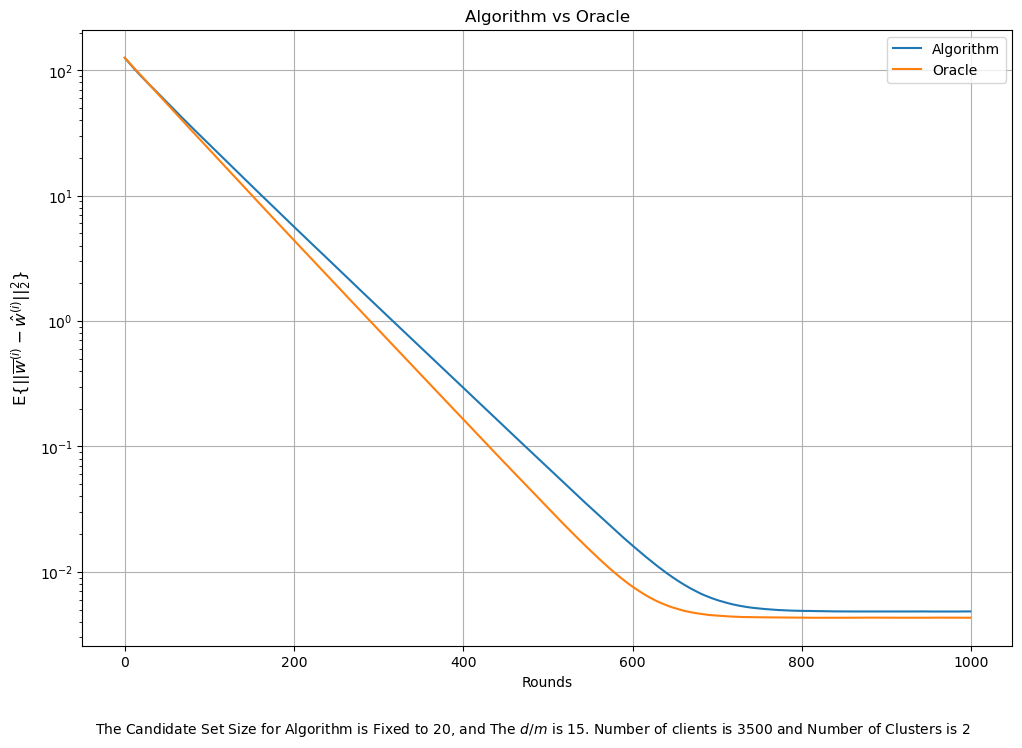

In [10]:
x = np.arange(NUM_ROUNDS)
fig = plt.figure(figsize=(12, 8))
plt.plot(x, mean_hist_MSE_w, label='Algorithm')
plt.plot(x, mean_hist_MSE_w_oracle, label='Oracle')
plt.xlabel("Rounds")
plt.ylabel("E{${||\overline{w}^{(i)} - \hat{w}^{(i)} ||^2_2} $}", fontsize=12)
plt.title("Algorithm vs Oracle")
fig.text(0.5, 0.001, f"The Candidate Set Size for Algorithm is Fixed to {SUBSET_SIZE}, and The $d/m$ is {dm}. Number of clients is {NUM_CLIENTS} and Number of Clusters is {NUM_CLUSTERS}",
         horizontalalignment="center")
plt.grid(True)  #
plt.yscale('log')

plt.legend()
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\h'
<>:7: SyntaxWarning: invalid escape sequence '\h'
/var/folders/ts/1myp2gd51_q36f7s6wsx08z80000gn/T/ipykernel_7652/1321976956.py:7: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("E{${||{y}^{(i)} - \hat{y}^{(i)} ||^2_2} $}", fontsize=12)


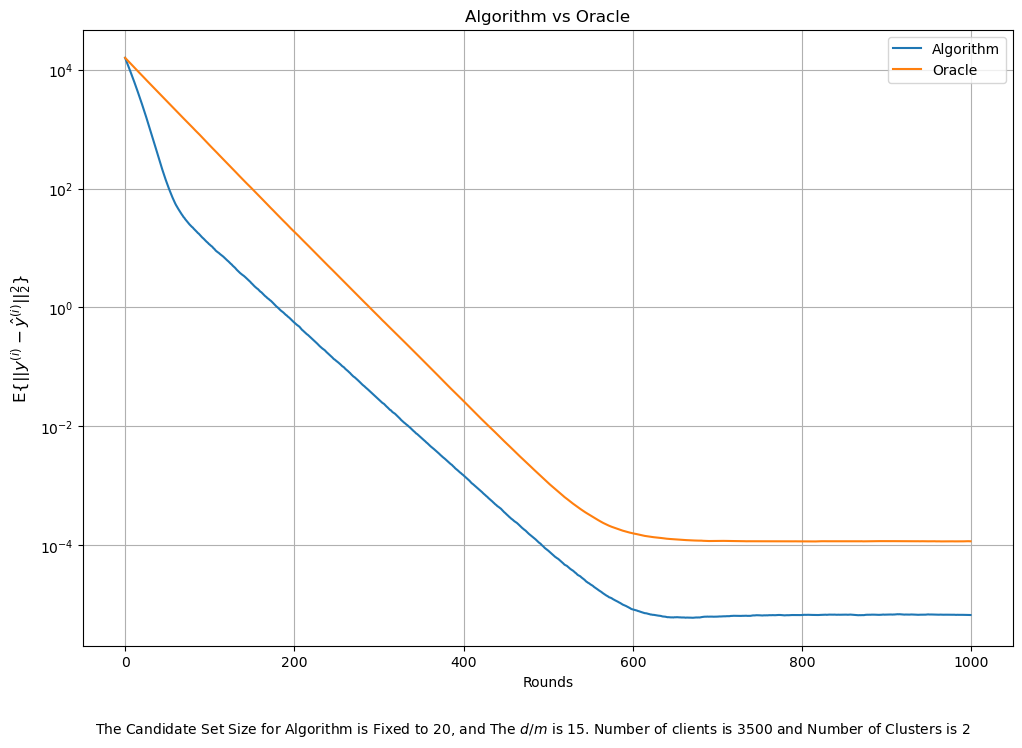

In [11]:
x = np.arange(NUM_ROUNDS)
fig = plt.figure(figsize=(12, 8))
plt.plot(x, mean_hist_MSE_y, label='Algorithm')
plt.plot(x, mean_hist_MSE_y_oracle, label='Oracle')
plt.yscale('log')
plt.xlabel("Rounds")
plt.ylabel("E{${||{y}^{(i)} - \hat{y}^{(i)} ||^2_2} $}", fontsize=12)
plt.title("Algorithm vs Oracle")
fig.text(0.5, 0.001, f"The Candidate Set Size for Algorithm is Fixed to {SUBSET_SIZE}, and The $d/m$ is {dm}. Number of clients is {NUM_CLIENTS} and Number of Clusters is {NUM_CLUSTERS}",
         horizontalalignment="center")
plt.grid(True)  #
plt.legend()
plt.show()

In [14]:
import csv

with open('../tex_PFL_via_regretmin/oracle_vs_algo_D_w.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    x = np.arange(len(mean_hist_MSE_w))
    # Write the header
    writer.writerow(['x', 'MSE_w_Algo', 'MSE_w_Oracle'])
    
    # Write the data
    for data_row in zip(x, mean_hist_MSE_w, mean_hist_MSE_w_oracle):
        writer.writerow(data_row)

In [15]:
with open('../tex_PFL_via_regretmin/oracle_vs_algo_L_w.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    x = np.arange(len(mean_hist_MSE_w))
    # Write the header
    writer.writerow(['x', 'MSE_y_Algo', 'MSE_y_Oracle'])
    
    # Write the data
    for data_row in zip(x, mean_hist_MSE_y, mean_hist_MSE_y_oracle):
        writer.writerow(data_row)